In [15]:
%%capture
## [TEMPLATE BEGIN]
## おまじない：実行中のノートブック名からOUTPUT_DIRを決めるコード
from pathlib import Path
from IPython import get_ipython; ip = get_ipython()
if '__vsc_ipynb_file__' in ip.user_ns:
    ## VS Codeで実行されている場合
    THIS_NOTEBOOK_PATH = Path(ip.user_ns['__vsc_ipynb_file__'])
else:
    !pip install ipynbname
    import ipynbname; THIS_NOTEBOOK_PATH = Path(ipynbname.path())
    if "%2F" in THIS_NOTEBOOK_PATH.stem:
        ## Google Colabで実行されている場合
        colab_ip = %system hostname -I   # uses colab magic to get list from bash
        colab_ip = colab_ip[0].strip()   # returns "172.28.0.12"
        colab_port = 9000                # could use 6000, 8080, or 9000
        import requests
        filename = requests.get(f"http://{colab_ip}:{colab_port}/api/sessions").json()[0]["name"]
        THIS_NOTEBOOK_PATH = Path(filename)
    else:
        ## それ以外の場合
        THIS_NOTEBOOK_PATH = THIS_NOTEBOOK_PATH

OUTPUT_DIR = Path("figures") / THIS_NOTEBOOK_PATH.stem
## [TEMPLATE END]

In [16]:
print("File output directory:", OUTPUT_DIR)
# Create the output directory if it does not exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

File output directory: figures/_wine_decision_tree_segmentation


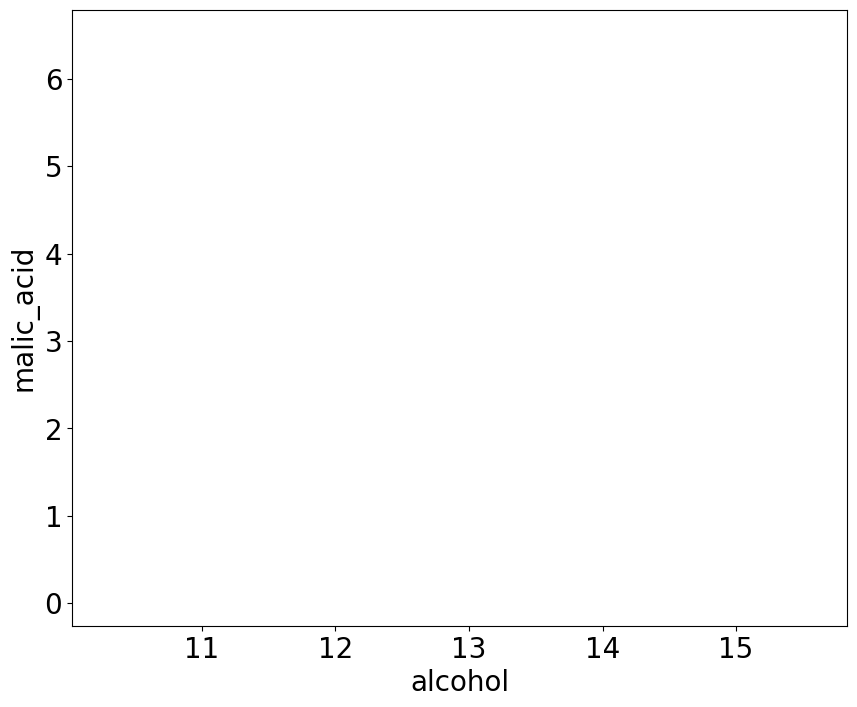

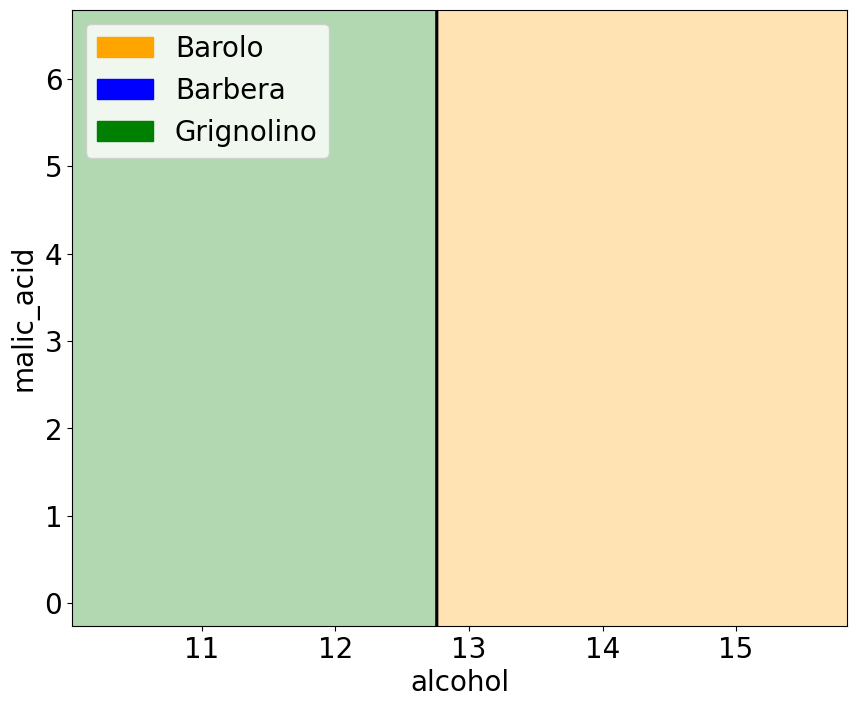

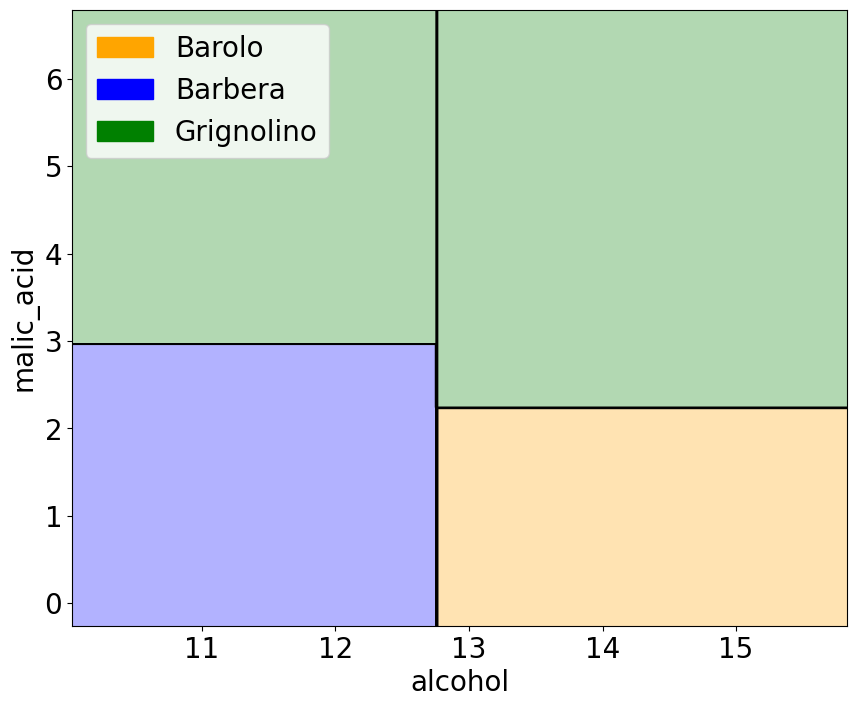

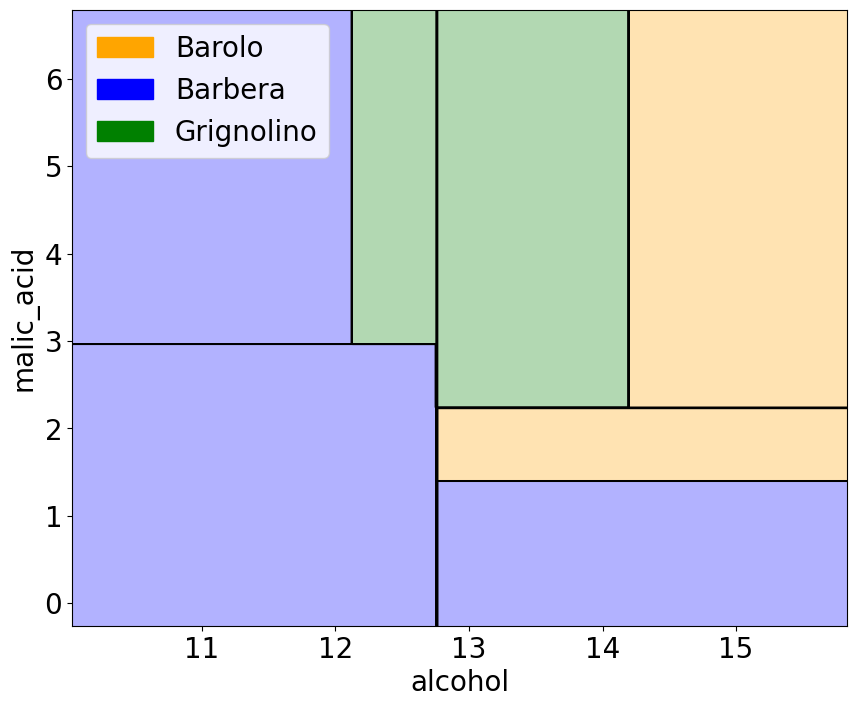

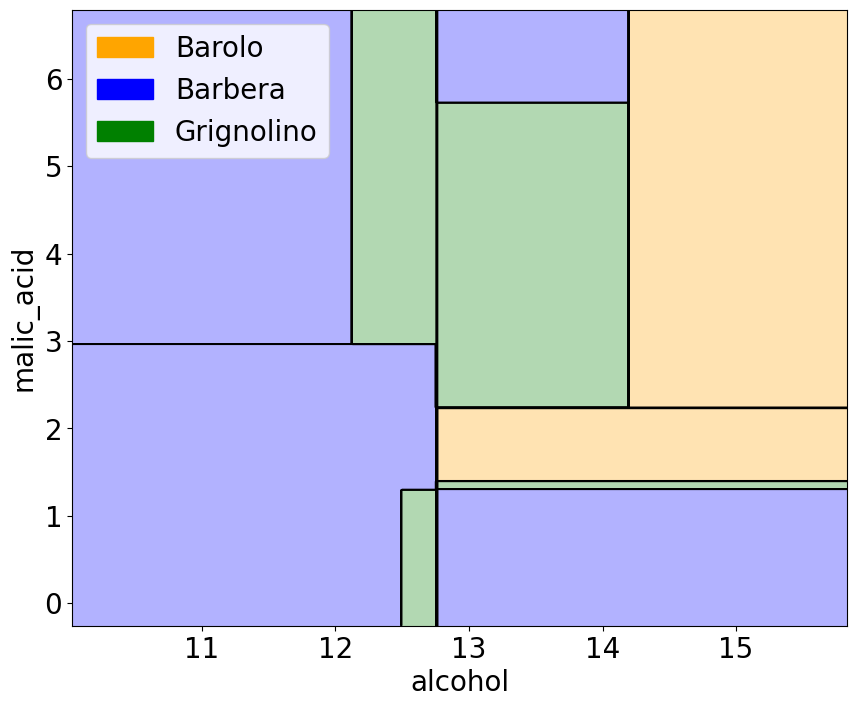

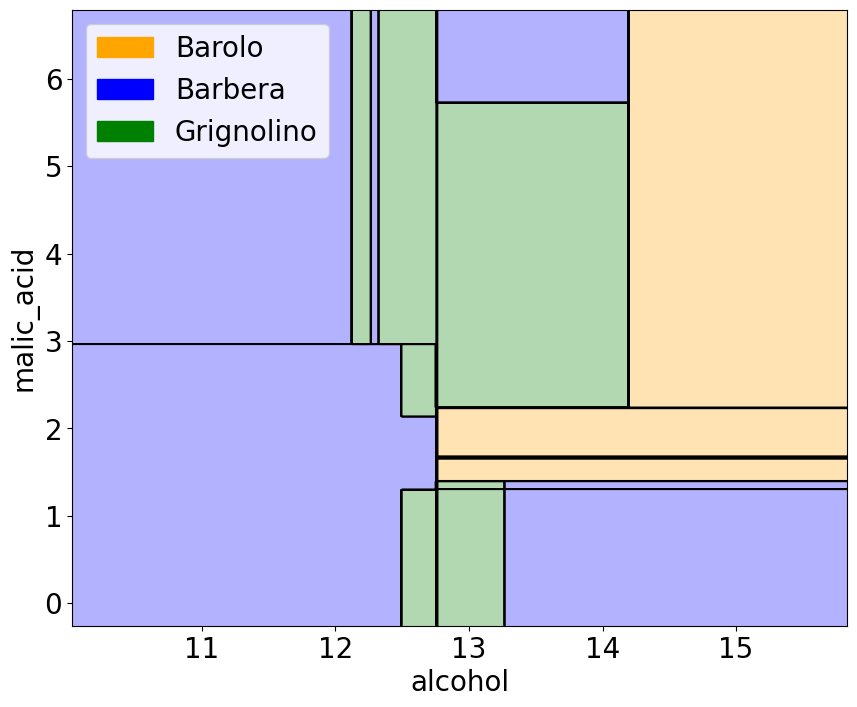

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine

# Set a random seed for reproducibility
random_seed = 42

# Load dataset
data = load_wine()
X = data.data[:, :2]  # Use the first two features for simplicity
y = data.target
features = data.feature_names[:2]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

# Define the range of depths to visualize
depths = range(1, 6)

# Create a mesh grid for plotting
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Define the color palette as a dictionary
color_palette = {
    'white': '#FFFFFF',
    'light_gray': '#D3D3D3',
    'gray': '#808080',
    'black': '#000000',
    'green': '#008000',
    'blue': '#0000FF',
    'light_blue': '#ADD8E6',
    'light_light_blue': '#E0FFFF',
    'yellow': '#FFFF00',
    'orange': '#FFA500',
    'dark_orange': '#FF8C00',
    'purple': '#800080'
}

# Create a new color map for the custom class names
target_names = ['Barolo', 'Barbera', 'Grignolino']
custom_colors = {
    'Barolo': color_palette['orange'],
    'Barbera': color_palette['blue'],
    'Grignolino': color_palette['green']
}
cmap_custom = ListedColormap([custom_colors[name] for name in target_names])

# Generate the "depth-zero" figure
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, np.zeros_like(xx), alpha=0.3, cmap=ListedColormap([color_palette['white']]))
plt.xlabel(features[0], fontsize=20)
plt.ylabel(features[1], fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
output_path = OUTPUT_DIR / 'decision_tree_depth_0.png'
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
plt.show()

# Generate the decision region plots for each depth
for depth in depths:
    plt.figure(figsize=(10, 8))
    
    # Train a classifier with the current depth
    clf = DecisionTreeClassifier(max_depth=depth, random_state=random_seed)
    clf.fit(X_train, y_train)
    
    # Predict the classifier output for the mesh using the original target values for consistency in Z
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary with custom class names
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_custom)
    
    # Overlay cumulative decision lines
    for d in range(1, depth + 1):
        clf_cumulative = DecisionTreeClassifier(max_depth=d, random_state=random_seed)
        clf_cumulative.fit(X_train, y_train)
        Z_cumulative = clf_cumulative.predict(np.c_[xx.ravel(), yy.ravel()])
        Z_cumulative = Z_cumulative.reshape(xx.shape)
        plt.contour(xx, yy, Z_cumulative, colors='black', linewidths=1)
    
    plt.xlabel(features[0], fontsize=20)
    plt.ylabel(features[1], fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    # Custom legend patches
    patch0 = mpatches.Patch(color=color_palette['orange'], label='Barolo')
    patch1 = mpatches.Patch(color=color_palette['blue'], label='Barbera')
    patch2 = mpatches.Patch(color=color_palette['green'], label='Grignolino')
    plt.legend(handles=[patch0, patch1, patch2], loc='upper left', fontsize=20)
    
    # Save the plot at the current depth
    output_path = OUTPUT_DIR / f'decision_tree_cumulative_depth_{depth}.png'
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.show()